In [1]:
from pynq import Overlay
import cffi 
import bnn
ROOT = "/opt/python3.6/lib/python3.6/site-packages/bnn/" 
ol = Overlay("procsys.bit")
ol.download()
ffi = cffi.FFI()
ffi.cdef("""
void load_parameters(const char* path);
unsigned int inference(const char* path, unsigned int results[64], int number_class, float *usecPerImage);
unsigned int* inference_multiple(const char* path, int number_class, int *image_number, float *usecPerImage, unsigned int enable_detail);
void free_results(unsigned int * result);
void deinit();
"""
)


/usr/local/lib/python3.6/dist-packages/pynq/pl_server/device.py:641: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


In [2]:
from pynq import Xlnk, Overlay
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import os
print(bnn.available_params(bnn.NETWORK_CNVW1A1))

classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1,"streetview",bnn.RUNTIME_HW)

['road-signs', 'streetview', 'cifar10']


In [3]:
print(classifier.classes)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '']


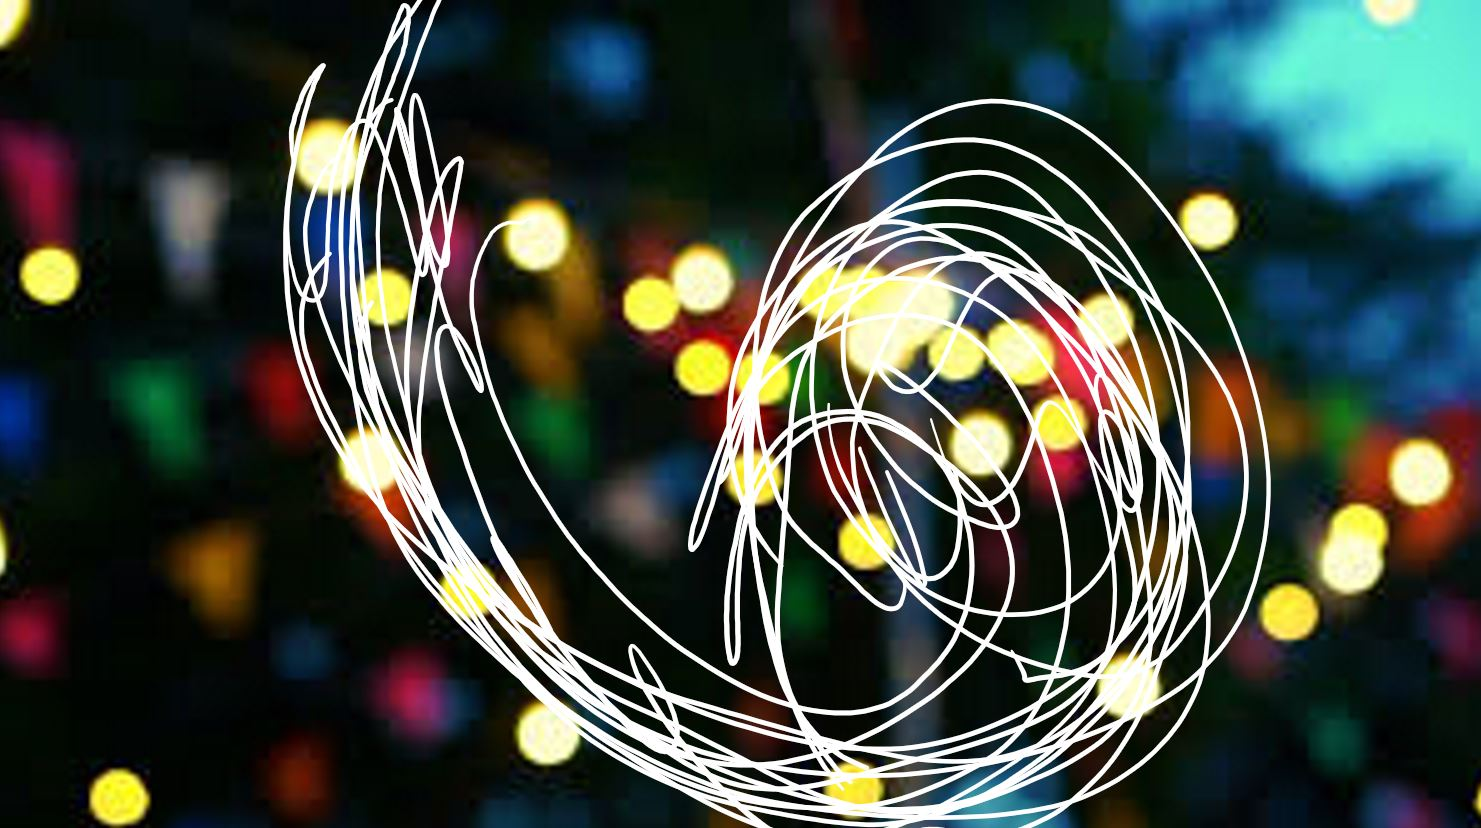

In [4]:
from PIL import Image
import numpy as np
img = Image.open('images/6-clumsy.jpg')
img

In [5]:
result_class_idx = classifier.classify_image(img)
print("Inferred number: {0}".format(classifier.class_name(result_class_idx)))

Inference took 1583.00 microseconds
Classification rate: 631.71 images per second
Inferred number: 6


In [6]:
sw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1, "streetview", bnn.RUNTIME_SW)
result_class_idx = sw_classifier.classify_image(img)
print("Inferred number: {0}".format(sw_classifier.class_name(result_class_idx)))

Inference took 1587156.00 microseconds
Classification rate: 0.63 images per second
Inferred number: 6


In [7]:
def get_files(path):
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            if '.jpg' in file or '.jpeg' in file or '.JPG' in file or '.JPEG' in file or '.png' in file:
                files.append(os.path.join(r, file))
    return files




In [8]:
PL_times =[]
PS_times=[]
images = get_files("images")
for image in images:
    true_image = Image.open(image)
    result_class_idx_hw = classifier.classify_image(true_image)
    print("Number Detected using FPGA: {0}".format(result_class_idx_hw))
    hardware_time=classifier.usecPerImage
    PL_times.append(hardware_time)
    print("PL Times" ,PL_times)
    
    sw_classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1, "streetview", bnn.RUNTIME_SW)
    result_class_idx_sw=sw_classifier.classify_image(true_image)
    print("Number Detected using PS only: {0}".format(result_class_idx_sw))
    software_time=sw_classifier.usecPerImage    
    PS_times.append(software_time)
    print("PS Times",PS_times)
    

   
    

Inference took 1582.00 microseconds
Classification rate: 632.11 images per second
Number Detected using FPGA: 4
PL Times [1582.0]
Inference took 1585693.00 microseconds
Classification rate: 0.63 images per second
Number Detected using PS only: 4
PS Times [1585693.0]
Inference took 1582.00 microseconds
Classification rate: 632.11 images per second
Number Detected using FPGA: 3
PL Times [1582.0, 1582.0]
Inference took 1584834.00 microseconds
Classification rate: 0.63 images per second
Number Detected using PS only: 3
PS Times [1585693.0, 1584834.0]
Inference took 1582.00 microseconds
Classification rate: 632.11 images per second
Number Detected using FPGA: 0
PL Times [1582.0, 1582.0, 1582.0]
Inference took 1583838.00 microseconds
Classification rate: 0.63 images per second
Number Detected using PS only: 0
PS Times [1585693.0, 1584834.0, 1583838.0]
Inference took 1583.00 microseconds
Classification rate: 631.71 images per second
Number Detected using FPGA: 2
PL Times [1582.0, 1582.0, 1582

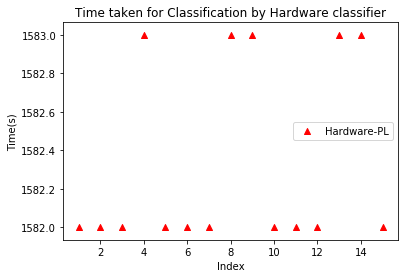

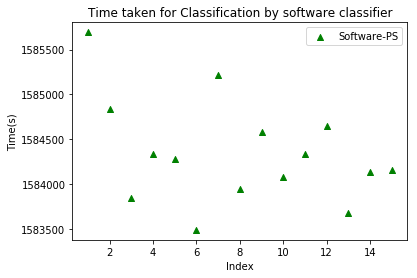

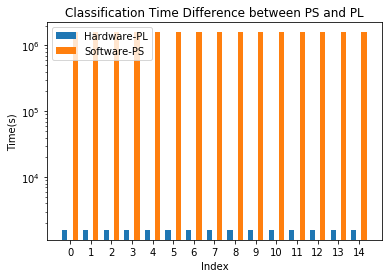

In [9]:



%matplotlib inline
import matplotlib.pyplot as plt

hw_bars = PL_times
sw_bars = PS_times



times=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.scatter(times,PL_times,c='red',marker='^',alpha=1)
plt.legend(["Hardware-PL"])
plt.xlabel('Index')
plt.ylabel('Time(s)')
plt.title('Time taken for Classification by Hardware classifier')
plt.show()

plt.scatter(times,PS_times,c='green',marker='^',alpha=1)
plt.legend(["Software-PS"])
plt.xlabel('Index')
plt.ylabel('Time(s)')
plt.title('Time taken for Classification by software classifier')
plt.show()

x_pos = np.arange(15)
fig, ax = plt.subplots()
ax.bar(x_pos - 0.25, PL_times, 0.25)
ax.bar(x_pos + 0.25, PS_times, 0.25)
ax.set_xticks(x_pos)
plt.legend(["Hardware-PL","Software-PS"])
plt.semilogy()
plt.title('Classification Time Difference between PS and PL')
plt.xlabel('Index')
plt.ylabel('Time(s)')
plt.show()

# times=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# plt.plot(times,PL_times)
# plt.plot(times,PS_times)
# plt.show()




In [10]:
xlnk = Xlnk();
xlnk.xlnk_reset()